In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from matplotlib.legend_handler import HandlerLine2D
import math
from scipy.stats import beta

In [ ]:
# https://stackoverflow.com/questions/19125722/adding-a-matplotlib-legend
def formatFloat(fmt, val):
  ret = fmt % val
  if ret.startswith("0."):
    return ret[1:]
  if ret.startswith("-0."):
    return "-" + ret[2:]
  return ret

def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_ls("-")
    handle.set_marker(".")

def plot_network(G):
  pos = nx.circular_layout(G)
  plt.figure(figsize = (12, 12))
  nx.draw_networkx(G, pos)
  plt.show()

# plot the percentage of correct majority votes for each number of agents
def plot_sim_avg(perc, perc_majority, ns, inquiry_accs, inquiry_chance, listen_chance):
  for i in range(len(perc)):
    color = ['grey', 'lime', 'blue'][i]
    label = "p="+formatFloat("%.2f", inquiry_accs[i])
    if i==0: label += f" (act="+formatFloat("%.2f", inquiry_chance)+" & com="+formatFloat("%.2f", listen_chance)+")"
    plt.plot(perc[i], color=color, ls='--', label=label)
    plt.plot(perc_majority[i], color=color)
    plt.fill_between(list(range(len(ns))), perc[i], perc_majority[i], color=color, alpha=0.2)
  plt.xticks(np.linspace(0, len(ns), num=6), labels=np.linspace(0, 100, num=6, dtype=int))
  plt.yticks(rotation=90)
  plt.xlabel("Net Size")
  plt.ylabel("Percentage Correct Vote")
  plt.ylim(0, 100)
  plt.legend(loc='lower right', frameon=False, handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})

In [17]:
N_BINS = 10
LIN = np.linspace(0.0, 1.0, num=N_BINS)
dist = beta(2, 1)
BINS = np.array([dist.pdf(x) for x in LIN])

# set k so that the resulting graph density is as close as possible to the desired density
def get_k(n, density):
  max_links = n*(n-1)/2
  links = max_links * density
  k = 2*links / n
  k_lower = int(k - k%2)
  k_upper = k_lower + 2
  if k_lower > 0 and abs((n*k_lower/2) - links) < abs((n*k_upper/2) - links):
    return k_lower
  else:
    return k_upper

# Create small-world network
def init_network(n, k):
  G = nx.connected_watts_strogatz_graph(n=n, k=k, p=0.5, tries=100) # p not given in the paper
  return nx.to_numpy_array(G) # Matrix of undirected edges

def init_agents(G, fixed_trust):
  A = [dict() for _ in range(G.shape[0])] # List of agents with their parameters
  for i,d in enumerate(A):
    d['p_belief'] = 0.5 # an inquirer’s (initial) degree of belief in p (P(H) in the paper)
    d['p_belief_shadow'] = d['p_belief'] # belief for the shadow agent, which should not be influenced by communication
    if not fixed_trust:
      d['inquiry_trust'] = BINS.copy() # the inquirer’s degree of trust in her own inquiries
      d['inquiry_trust_shadow'] = BINS.copy()
      d['listen_trust'] = np.array([BINS.copy() for x in G[i] if x==1]) # the recipient's trust in the sender
  return A

def get_expected_trust(trust):
  prod = np.multiply(LIN, trust)
  return np.sum(prod)/len(trust)

def update_trust_single(belief, trust, inquiry):
  et = get_expected_trust(trust)
  c = belief
  if not inquiry: c = 1 - c
  c_bar = 1 - c
  for i in range(len(trust)):
    ro = LIN[i]
    trust[i] = trust[i] * ((ro*c + (1-ro)*c_bar) / (et*c + (1-et)*c_bar))
  return trust, et

def update_belief_single(belief, t, inquiry):
  if not inquiry: t = 1 - t
  t_bar = 1 - t
  belief = (belief * t) / (belief * t + (1 - belief) * t_bar)
  return belief

def update_belief_trust_single(belief, trust, inquiry):
  trust, t = update_trust_single(belief, trust, inquiry)
  belief = update_belief_single(belief, t, inquiry)
  return belief, trust

def update_trust_multiple(belief, trusts, inquiries):
  expected_trusts = np.empty(len(trusts))
  for i in range(len(trusts)):
    trusts[i], expected_trusts[i] = update_trust_single(belief, trusts[i], inquiries[i])
  return trusts, expected_trusts

def update_belief_multiple(belief, expected_trusts, inquiries):
  pos = [x for i,x in enumerate(expected_trusts) if inquiries[i]]
  pos_prod = math.prod(pos)
  pos_prod_bar = math.prod([1-x for x in pos])
  neg = [x for i,x in enumerate(expected_trusts) if not inquiries[i]]
  neg_prod = math.prod(neg)
  neg_prod_bar = math.prod([1-x for x in neg])

  return (belief * pos_prod * neg_prod_bar) / (belief * pos_prod * neg_prod_bar + (1 - belief) * pos_prod_bar * neg_prod)

def update_belief_trust_multiple(belief, trusts, inquiries):
  trusts, expected_trusts = update_trust_multiple(belief, trusts, inquiries)
  belief = update_belief_multiple(belief, expected_trusts, inquiries)
  return belief, trusts

def get_votes(A):
  votes_for, votes_for_shadow = 0, 0
  for a in A:
    if a['p_belief'] > 0.5: votes_for += 1
    elif a['p_belief'] == 0.5: votes_for += 0.5 # vote is split
    if a['p_belief_shadow'] > 0.5: votes_for_shadow += 1
    elif a['p_belief_shadow'] == 0.5: votes_for_shadow += 0.5
  return votes_for, votes_for_shadow

def get_messages(G, A, i, listen_chance, assertion_threshold):
  senders, inquiries = [], []
  a2 = -1 # idx of other agent in A[i]['listen_trust']
  for j, link in enumerate(G[i]):
    if link==1:
      a2 += 1
      if assertion_threshold > 0.5 and abs(0.5-A[j]['p_belief']) >= assertion_threshold-0.5:
        # truth
        inquiry = A[j]['p_belief'] > 0.5
      elif assertion_threshold < 0.5 and abs(0.5-A[j]['p_belief']) <= assertion_threshold-0.5:
        # lie
        inquiry = A[j]['p_belief'] < 0.5
      elif assertion_threshold == 0.5:
        # random
        inquiry = np.random.rand() < 0.5
      else: continue

      if np.random.rand() < listen_chance:
        senders.append(a2)
        inquiries.append(inquiry)
  return senders, inquiries

def run_sim(n, p, k, assertion_threshold, inquiry_acc, inquiry_chance, listen_chance, fixed_trust):
  G = init_network(n, k)
  A = init_agents(G, fixed_trust)
  for epoch in range(50):
    agents = np.array(range(len(A)))
    np.random.shuffle(agents)
    for i in agents:
      senders, inquiries = get_messages(G, A, i, listen_chance, assertion_threshold)

      # potentially inquire from outside the network
      if np.random.rand() < inquiry_chance:
        inquiry = np.random.rand() < inquiry_acc
        if not p: inquiry = not inquiry
        if not fixed_trust: A[i]['p_belief_shadow'], A[i]['inquiry_trust_shadow'] = update_belief_trust_single(A[i]['p_belief_shadow'], A[i]['inquiry_trust_shadow'], inquiry)
        else: A[i]['p_belief_shadow'] = update_belief_single(A[i]['p_belief_shadow'], 0.66, inquiry)
        senders.append(-1) # self
        inquiries.append(inquiry)

      # update belief and trusts
      if senders != []:
        if not fixed_trust:
          if -1 in senders:
            trusts = list(A[i]['listen_trust'][senders[:-1]]) + [A[i]['inquiry_trust']]
          else:
            trusts = A[i]['listen_trust'][senders]

          A[i]['p_belief'], new_trusts = update_belief_trust_multiple(A[i]['p_belief'], trusts, inquiries)

          if -1 in senders:
            if len(senders) > 1: A[i]['listen_trust'][senders[:-1]] = new_trusts[:-1]
            A[i]['inquiry_trust'] = new_trusts[-1]
          else:
            A[i]['listen_trust'][senders] = new_trusts

        else:
          A[i]['p_belief'] = update_belief_multiple(A[i]['p_belief'], [0.66 for _ in range(len(inquiries))], inquiries)

  return get_votes(A)

In [ ]:
def simulate(fixed_options, runs):
  ns = np.linspace(4, 100, num=21, dtype=int)
  inquiry_accs = [0.75, 0.66, 0.55]
  ks = [get_k(n, density=0.05) for n in ns] # density or k not given in the paper
  for assertion_threshold in [0.8, 0.51]: # the degree of confidence in a proposition (“p” or “not-p”) required for the sender to submit a corresponding message to the recipient(s).
    for fixed_trust in fixed_options: # 'update agents' vs 'fixed trust agents' in the paper
      for inquiry_chance in [0.2, 0.5]: # the probability that the inquirer will conduct an inquiry ('act' in the paper)
        listen_chance = [x for x in [0.5, 0.2] if x != inquiry_chance][0] # the probability that the recipient will listen to a message she receives (= chance to send for the other agent, 'com' in the paper)
        perc, perc_shadow, perc_majority, perc_majority_shadow = [], [], [], []
        for inquiry_acc in inquiry_accs: # the reliability of the inquirer’s own inquiries ('p' in the paper)
          print(f"assertion {assertion_threshold}, fixed {fixed_trust}, inquiry chance {inquiry_chance}, inquiry acc {inquiry_acc}")
          perc.append([]); perc_shadow.append([]); perc_majority.append([]); perc_majority_shadow.append([])
          for k_idx, n in enumerate(ns): # number of agents
            if n == ns[0]: print("n =", end=' ')
            print(n, end=', ')
            if n == ns[-1]: print("")
            n_correct, n_correct_shadow, n_majority_correct, n_majority_correct_shadow = 0, 0, 0, 0
            for run in range(runs): # take average over 100 simulations for each set of parameters
              p = bool(run < runs*0.6) # p is true in 60% of the simulations
              votes_for, votes_for_shadow = run_sim(n, p, ks[k_idx], assertion_threshold, inquiry_acc, inquiry_chance, listen_chance, fixed_trust)
              if p:
                n_correct += votes_for/n; n_correct_shadow += votes_for_shadow/n
              else:
                n_correct += 1 - (votes_for/n); n_correct_shadow += 1 - (votes_for_shadow/n)
              if (votes_for > n/2 and p) or (votes_for < n/2 and not p): n_majority_correct += 1
              if (votes_for_shadow > n/2 and p) or (votes_for_shadow < n/2 and not p): n_majority_correct_shadow += 1

            perc[-1].append(n_correct/runs*100); perc_shadow[-1].append(n_correct_shadow/runs*100); perc_majority[-1].append(n_majority_correct/runs*100); perc_majority_shadow[-1].append(n_majority_correct_shadow/runs*100)
        plt.figure()
        plot_sim_avg(perc, perc_majority, ns, inquiry_accs, inquiry_chance, listen_chance)
        plt.title(f"shadow = False, assertion = {assertion_threshold}, fixed = {fixed_trust}")
        plt.figure()
        plot_sim_avg(perc_shadow, perc_majority_shadow, ns, inquiry_accs, inquiry_chance, listen_chance)
        plt.title(f"shadow = True, assertion = {assertion_threshold}, fixed = {fixed_trust}")
        plt.show()

assertion 0.8, fixed False, inquiry chance 0.2, inquiry acc 0.75
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.8, fixed False, inquiry chance 0.2, inquiry acc 0.66
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.8, fixed False, inquiry chance 0.2, inquiry acc 0.55
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 


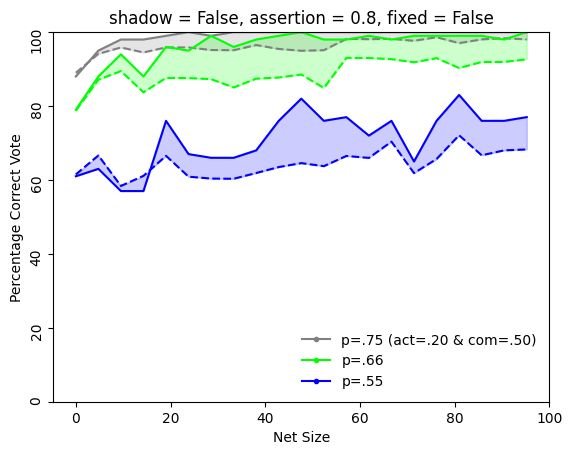

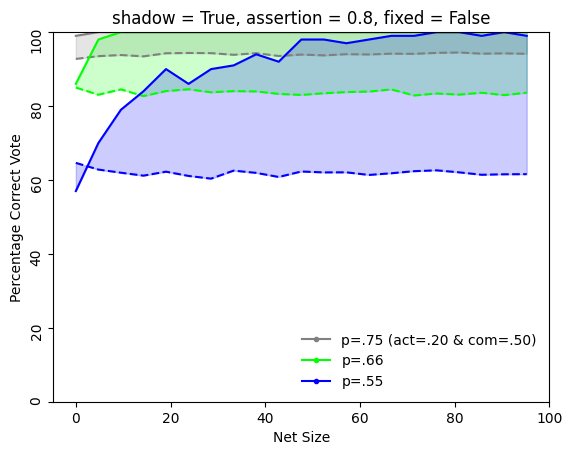

assertion 0.8, fixed False, inquiry chance 0.5, inquiry acc 0.75
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.8, fixed False, inquiry chance 0.5, inquiry acc 0.66
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.8, fixed False, inquiry chance 0.5, inquiry acc 0.55
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 


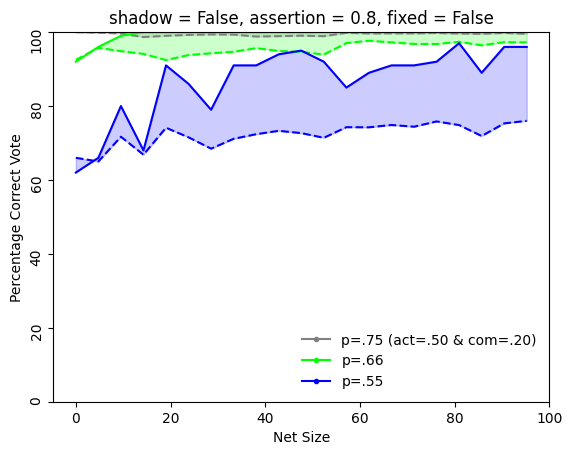

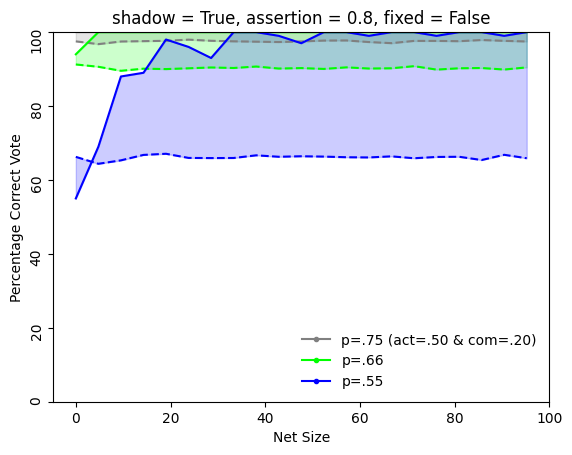

assertion 0.51, fixed False, inquiry chance 0.2, inquiry acc 0.75
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.51, fixed False, inquiry chance 0.2, inquiry acc 0.66
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.51, fixed False, inquiry chance 0.2, inquiry acc 0.55
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 


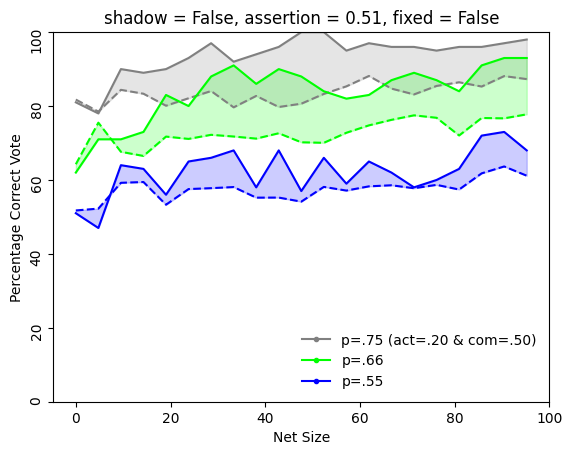

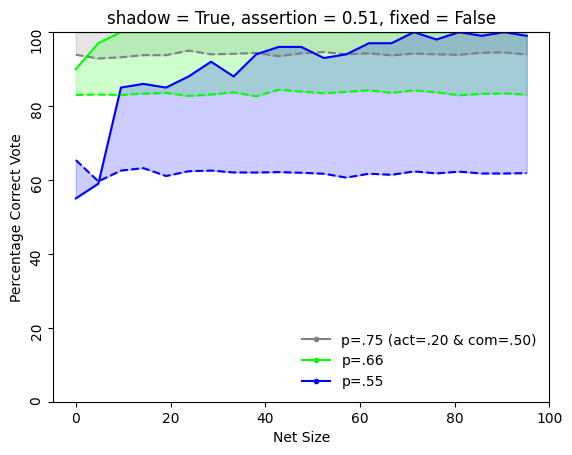

assertion 0.51, fixed False, inquiry chance 0.5, inquiry acc 0.75
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.51, fixed False, inquiry chance 0.5, inquiry acc 0.66
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.51, fixed False, inquiry chance 0.5, inquiry acc 0.55
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 


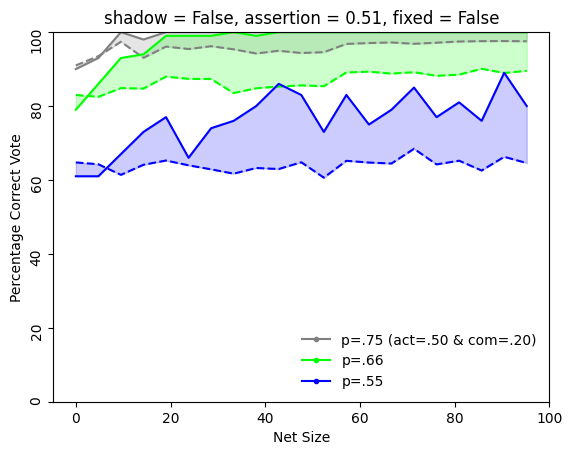

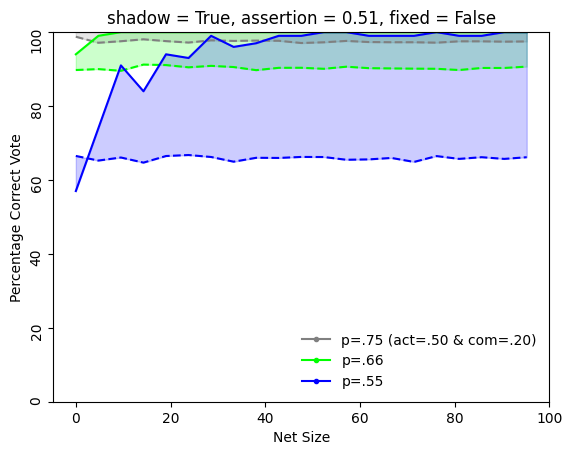

In [ ]:
simulate(fixed_options=[False], runs=100)

assertion 0.8, fixed True, inquiry chance 0.2, inquiry acc 0.75
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.8, fixed True, inquiry chance 0.2, inquiry acc 0.66
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.8, fixed True, inquiry chance 0.2, inquiry acc 0.55
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 


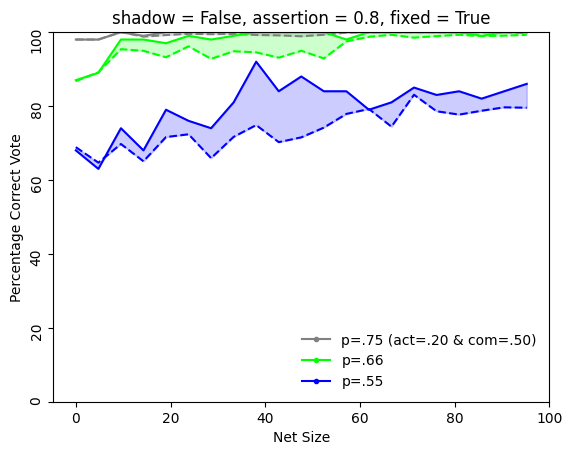

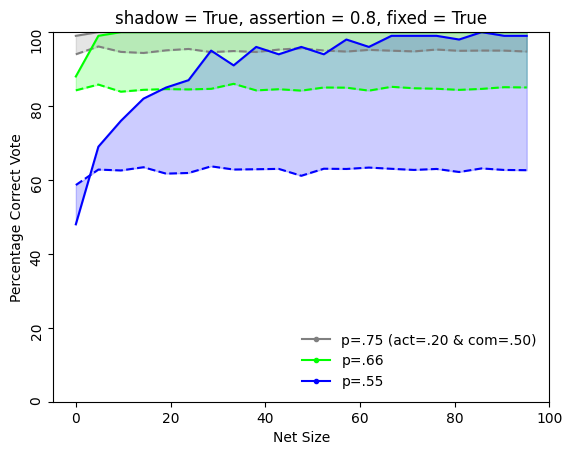

assertion 0.8, fixed True, inquiry chance 0.5, inquiry acc 0.75
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.8, fixed True, inquiry chance 0.5, inquiry acc 0.66
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.8, fixed True, inquiry chance 0.5, inquiry acc 0.55
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 


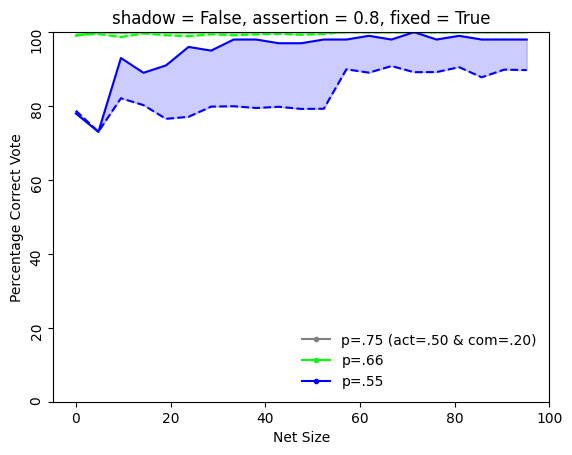

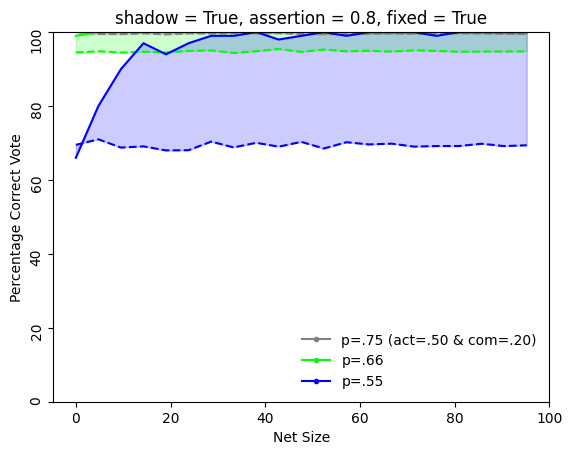

assertion 0.51, fixed True, inquiry chance 0.2, inquiry acc 0.75
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.51, fixed True, inquiry chance 0.2, inquiry acc 0.66
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.51, fixed True, inquiry chance 0.2, inquiry acc 0.55
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 


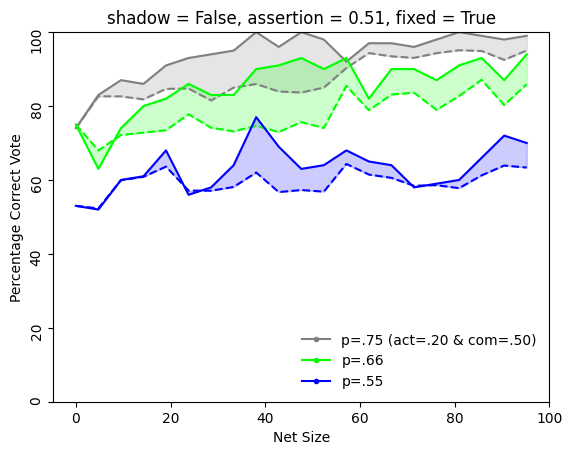

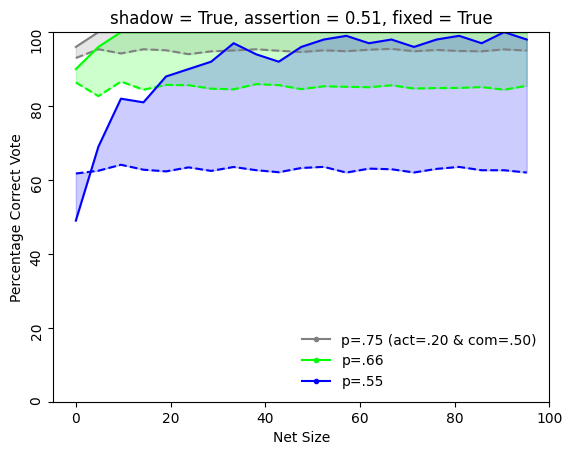

assertion 0.51, fixed True, inquiry chance 0.5, inquiry acc 0.75
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.51, fixed True, inquiry chance 0.5, inquiry acc 0.66
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 
assertion 0.51, fixed True, inquiry chance 0.5, inquiry acc 0.55
n = 4, 8, 13, 18, 23, 28, 32, 37, 42, 47, 52, 56, 61, 66, 71, 76, 80, 85, 90, 95, 100, 


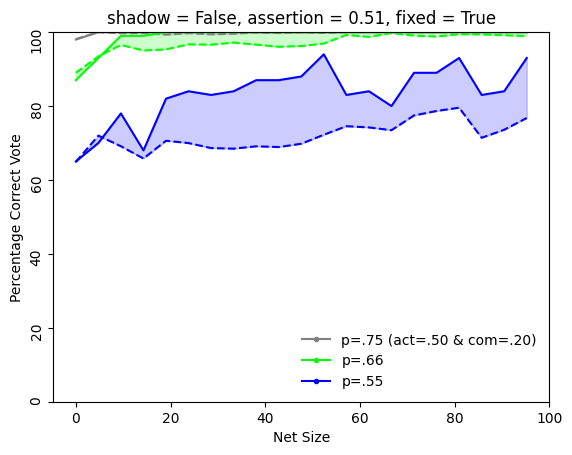

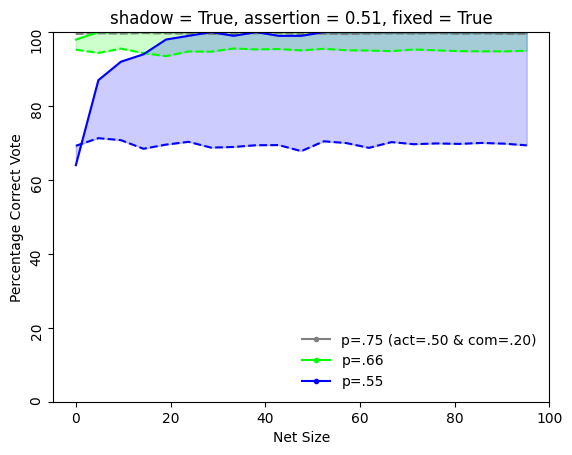

In [ ]:
simulate(fixed_options=[True], runs=100)